In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [54]:
df = pd.read_csv("assembled.csv", index_col=0)
df['refs'] = df['refs'].apply(ast.literal_eval)

In [55]:
df

,body,subject,date,from,refs
telegram_index,,,,,
3_atel,In addendum of ATEL #2: Additional Information...,Improved Coordinates for GB971227,1997-12-28,rutledge@rosat.mpe-garching.mpg.de,[]
2_atel,The following message was emailed to me this e...,GB971227,1997-12-28,rutledge@rosat.mpe-garching.mpg.de,[]
4_atel,The recent detection of delayed Gamma ray burs...,The Probable Connection Between Relativistic S...,1998-01-06,rutledge@rosat.mpe-garching.mpg.de,[]
5_atel,The optical transient (IAUC # 6788 ) of GRB 97...,GRB 971214,1998-01-12,rutledge@rosat.mpe-garching.mpg.de,[]
6_atel,GRB980109 field was observed by the OGLE colla...,GRB980109,1998-01-18,rutledge@rosat.mpe-garching.mpg.de,[]
...,...,...,...,...,...
16033_atel,"The Large Area Telescope (LAT), one of the two...",Fermi LAT detection of increasing gamma-ray ac...,2023-05-10,federica.giacchino@roma2.infn.it,"[2980_atel, 2966_atel]"
16034_atel,We report the following classification from a ...,Spectroscopic Classification of an optical tra...,2023-05-12,crojasbr@ucsc.edu,[]
16035_atel,"The Large Area Telescope (LAT), one of the two...",Fermi-LAT detection of enhanced gamma-ray acti...,2023-05-12,Denis.bernard@in2p3.fr,[]


### Clean the self-references

In [56]:
no_self_refs = []
all_available_telegrams = df.index

for i, r in df.iterrows():
    this_refs = r.refs.copy()
    this_owner = r['from']
    for reference in this_refs:
        if reference in all_available_telegrams and df.loc[reference]['from'] == this_owner:
            this_refs.remove(reference)
        else: pass
    no_self_refs.append(this_refs)

In [57]:
df['refs_wo_self'] = no_self_refs

### Calc references for each telegram

In [58]:
telegram_is_ref_from = {telegram_idx: [] for telegram_idx in df.index.values}

for i, r in df.iterrows():
    for ref_id in r.refs_wo_self:
        if ref_id not in telegram_is_ref_from.keys():
            pass
        else:
            telegram_is_ref_from[ref_id].append(i)

In [59]:
telegram_is_ref_from['8_atel']

['46_atel', '57_atel']

In [60]:
df.loc['46_atel'].refs

['32_atel', '9_atel', '8_atel']

In [61]:
df['n_cited'] = [len(r) for r in telegram_is_ref_from.values()]

In [62]:
df.n_cited.mean()

2.905031172973757

### See citations distribution

In [80]:
median = np.median(df.n_cited)
top_25 = np.percentile(df.n_cited.values, 75)
top_20 = np.percentile(df.n_cited.values, 80)
top_5 = np.percentile(df.n_cited.values, 95)

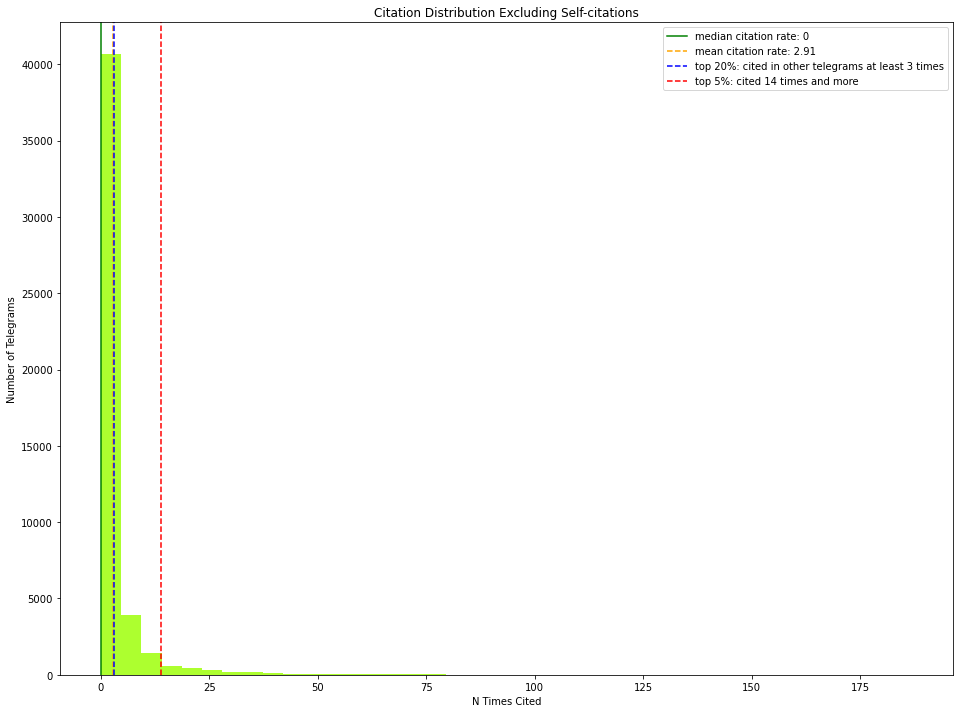

In [85]:
plt.rcParams["figure.figsize"] = (16,12)
plt.hist(df.n_cited.values, bins=40, color='greenyellow')
plt.axvline(median, color='green', linestyle='-', label=f'median citation rate: {int(median)}')
plt.axvline(np.mean(df.n_cited), color='orange', linestyle='--', label=f'mean citation rate: {round(np.mean(df.n_cited), 2)}')
# plt.axvline(top_25, color='blue', linestyle='--', label=f'top 25%: cited in other telegrams at least {int(top_25)} times')
plt.axvline(top_20, color='blue', linestyle='--', label=f'top 20%: cited in other telegrams at least {int(top_20)} times')
plt.axvline(top_5, color='red', linestyle='--', label=f'top 5%: cited {int(top_5)} times and more')
plt.xlabel('N Times Cited')
plt.ylabel("Number of Telegrams")
plt.legend(loc="upper right")
plt.title("Citation Distribution Excluding Self-citations")
plt.show()

### Assign class labels: 
 `0` for the least interesting (cited less than 3 times)
 
 `1` for interesting (cited more than 3 times, up to 14)
 
 `2` for very insteresting (14 citations and above)

In [71]:
df['citation_class'] = df.n_cited.apply(lambda x: 0 if x < top_20 else 1 if top_20 <= x < top_5 else 2)

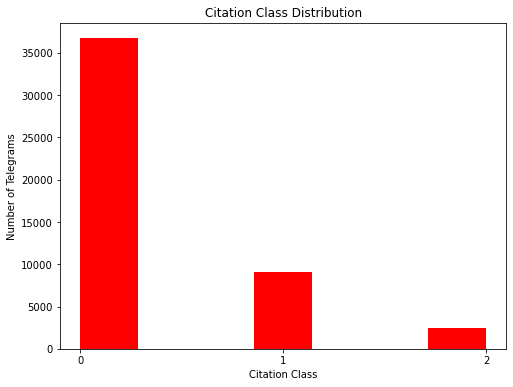

In [86]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.hist(df.citation_class.values, bins=7, color='red')
plt.xlabel('Citation Class')
plt.ylabel("Number of Telegrams")
plt.xticks([0, 1, 2])
plt.title("Citation Class Distribution")
plt.show()

In [79]:
# save the labels
df[['n_cited', 'citation_class']].to_csv("labels.csv", index=True)